In [22]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    !git config user.email "sambitdash@gmail.com"
    !git config user.name "Sambit Kumar Dash"
    !git config user.password "your password"
    !git status

/content/EVA-2-Group/Session-19
On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	generator_plot.png

nothing added to commit but untracked files present (use "git add" to track)


In [92]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


In [93]:
%tensorflow_version 1.x

from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainx, testx = imgs['hatch'][:300,:,:,:], imgs['hatch'][300:,:,:,:]

trainy, testy = np.zeros(trainx.shape[0], dtype=float), np.zeros(testx.shape[0], dtype=float)

trainx = np.append(trainx, imgs['sedan'][:375,:,:,:], axis=0)
testx = np.append(testx, imgs['sedan'][375:,:,:,:], axis=0)

ltrain, ltest = trainx.shape[0] - trainy.shape[0], testx.shape[0] - testy.shape[0]

trainy, testy = np.append(trainy, np.ones(ltrain, dtype=float)), np.append(testy, np.ones(ltest, dtype=float))


print(trainx.shape, "y", trainy.shape)
print(testx.shape, 'y', testy.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainx)

trainX, trainY = trainx, trainy
testX, testY   = testx, testy

for i in range(9):
    iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=True)
    x, y = iterate.next()
    trainX, trainY = np.append(trainX, x, axis=0), np.append(trainY, y, axis=0)

for i in range(9):
    iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=True)
    x, y = iterate.next()
    testX, testY = np.append(testX, x, axis=0), np.append(testY, y, axis=0)


print(trainX.shape, "y", trainY.shape)
print(testX.shape, "y", testY.shape)

trainx, trainy = trainX, trainY
testx, testy   = testX, testY

trainx = trainx.astype('float32') / 255
testx  = testx.astype('float32') / 255

trainx_mean = np.mean(trainx, axis=(0, 1, 2))
trainx_std  = np.std(trainx, axis=(0, 1, 2))

print(trainx_mean, trainx_std)

trainx -= trainx_mean
trainx /= trainx_std

testx -= trainx_mean
testx /= trainx_std

trainX, trainY = trainx, trainy #utils.to_binary(trainy)
testX,  testY  = testx,  testy  #utils.to_binary(testy)

min_pix, max_pix = trainX.min(), trainX.max()

print(min_pix, max_pix)
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)

(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
(6750, 64, 64, 3) y (6750,)
(670, 64, 64, 3) y (670,)
[0.35538003 0.3471713  0.343129  ] [0.3870093  0.33295637 0.33596805]
-1.0426931 1.9607034
-1.0426931 1.9607034
(6750, 64, 64, 3) (6750,)


In [94]:
print(testY)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.

In [0]:
BATCH_SIZE = 128
WT_DECAY   = 1e-5
LRFNEPOCH  = 4
MOMENTUM   = 0.9
EPOCHS     = 300
LEARNING_RATE = 0.01

from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D, GlobalAvgPool1D
from tensorflow.keras.initializers import zeros

def ResConv(x, kernel=(3, 3), depth=32, maxpool=False):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if maxpool :
        x = MaxPool2D()(x)
    x = Conv2D(depth, kernel, padding='same', use_bias=False)(x)
    return x

def ResUnit(x, depth=32, maxpool=False):
    x = ResConv(x, depth=depth, maxpool=maxpool)
    x = ResConv(x, depth=depth)
    return x
    
def ResNetBlock(x, nunit, depth=32, maxpool=False, name="Block-1"):
    assert nunit > 0, "Ensure there are at least 1 unit in the ResNet Block"
    nunit -= 1
    if maxpool:
        xskip = Conv2D(depth, (1, 1), strides=2, use_bias=False)(x)
    else: 
        xskip = x
    x = add([ResUnit(x, depth=depth, maxpool=maxpool), xskip])
    if nunit >= 1:
        nunit -= 1
        for i in range(nunit):
            x = add([ResUnit(x, depth=depth), x])
        x = add([ResUnit(x, depth=depth), x], name=name)
    return x

# Returns latent vector of 512 bytes        
def ResNet18(x):
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = MaxPool2D((3, 3),  strides=2, padding='same')(x)
    
    nunits   = (2, 2, 2, 2)
    maxpools = (False, True, True, True)
    depths   = (64, 128, 256, 512)
    
    for i in range(4):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i], name="Block-"+str(i))
    x = GlobalAvgPool2D()(x)
    return x

# Returns latent vector of 256 bytes
def ResNet9(x):
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = MaxPool2D((3, 3),  strides=2, padding='same')(x)
    
    nunits   = (2, 3, 2)
    maxpools = (False, True, True)
    depths   = (64, 128, 256)
    
    for i in range(3):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i], name="Block-"+str(i))
    x = GlobalAvgPool2D()(x)
    return x

In [177]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

def l2_weights(model):
    l2 = 0
    for layer in model.layers: 
        wt = layer.weights
        if len(wt) > 0:
            l2 += K.sum(K.pow(wt, 2))
    return l2

def reg_loss(model):
    def rloss(y_true, y_pred):
        return model.l2_reg*l2_weights(model)
    return rloss

def loss_with_regularization(model):
    def loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred, True) + reg_loss(model)(y_true, y_pred)
    return loss

def bacc(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype=y_true.dtype)
    return K.mean(K.equal(y_true, y_pred), axis=-1)

def model_init(optimizer=None):
    xin = Input(shape=(64, 64, 3), name="Input")
    x = ResNet9(xin)
    y = Dense(1, use_bias=False, activation='sigmoid')(x)
    model = Model(xin, y)
    model.l2_reg = K.variable(value=WT_DECAY, dtype='float32', name='reg_loss')
    if optimizer is None:
        optimizer = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
    model.compile(optimizer='adam', loss=loss_with_regularization(model), metrics=[bacc, reg_loss(model)])
    return model

model = model_init()
model.summary()

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1020 (Conv2D)            (None, 32, 32, 64)   9408        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_180 (MaxPooling2D (None, 16, 16, 64)   0           conv2d_1020[0][0]                
__________________________________________________________________________________________________
batch_normalization_840 (BatchN (None, 16, 16, 64)   256         max_pooling2d_180[0][0]          
___________________________________________________________________________________________

Epoch 1/4
53/53 [==============================] - 47s 879ms/step - loss: 0.7481 - bacc: 0.4976 - rloss: 0.0601 - val_loss: 0.7367 - val_bacc: 0.5448 - val_rloss: 0.0707
Epoch 2/4
53/53 [==============================] - 10s 194ms/step - loss: 0.7981 - bacc: 0.4519 - rloss: 0.1039 - val_loss: 0.8378 - val_bacc: 0.4776 - val_rloss: 0.1446
Epoch 3/4
53/53 [==============================] - 12s 227ms/step - loss: 0.8555 - bacc: 0.4444 - rloss: 0.1624 - val_loss: 0.8363 - val_bacc: 0.4776 - val_rloss: 0.1432
Epoch 4/4
16/53 [========>.....................] - ETA: 7s - loss: 4039.5712 - bacc: 0.4658 - rloss: 4038.8586

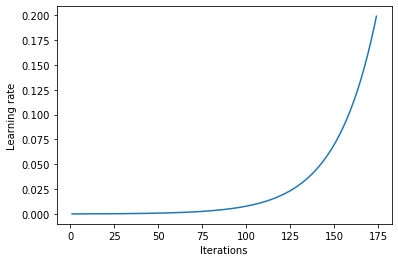

In [178]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration > 1 and smoothed_loss > self.best_loss * 1000:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=1):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
    
model = model_init()
lr_finder = LR_Finder(start_lr=1e-4, end_lr=1, step_size=np.ceil(trainX.shape[0]/(BATCH_SIZE/LRFNEPOCH)))
model.fit_generator(datagen.flow(trainX, trainY, batch_size = BATCH_SIZE),
                    epochs=LRFNEPOCH,
                    validation_data = (testX, testY), verbose=1,
                    callbacks=[lr_finder])
lr_finder.plot_lr()

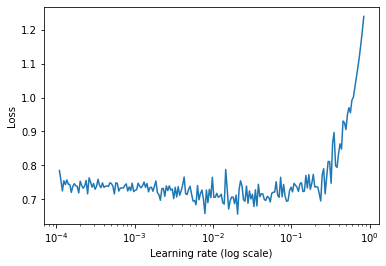

In [172]:
lr_finder.plot()

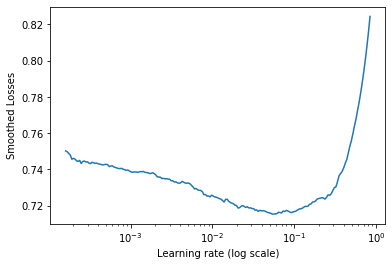

In [173]:
lr_finder.plot_smoothed_loss()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = 8 #int(np.sqrt(s / r))
            h = 8 #int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = 0.0 #np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(
        fill_mode = 'constant',
        cval=0,
        rotation_range=20,
        width_shift_range=8,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=8,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=min_pix, v_h=max_pix, pixel_level=False)
)
datagen.fit(trainX)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result)
    true_class = np.argmax(test_y)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['bacc'])+1),model_history.history['bacc'])
    axs[0].plot(range(1,len(model_history.history['val_bacc'])+1),model_history.history['val_bacc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['bacc'])+1),len(model_history.history['bacc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [176]:
import time
from datetime import datetime

# Compile the model
model = model_init()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(trainX, trainY, batch_size = BATCH_SIZE),
                                 epochs=100, shuffle = True,
                                 validation_data = (testX, testY), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(testX, testY, model))

Epoch 1/100
53/53 [==============================] - 45s 857ms/step - loss: 0.7508 - bacc: 0.4581 - rloss: 0.0569 - val_loss: 0.7457 - val_bacc: 0.4776 - val_rloss: 0.0558
Epoch 2/100
53/53 [==============================] - 9s 178ms/step - loss: 0.7489 - bacc: 0.4444 - rloss: 0.0558 - val_loss: 0.7481 - val_bacc: 0.4776 - val_rloss: 0.0562
Epoch 3/100
53/53 [==============================] - 11s 209ms/step - loss: 0.7500 - bacc: 0.4444 - rloss: 0.0569 - val_loss: 0.7505 - val_bacc: 0.4776 - val_rloss: 0.0576
Epoch 4/100
53/53 [==============================] - 11s 208ms/step - loss: 0.7516 - bacc: 0.4444 - rloss: 0.0584 - val_loss: 0.7523 - val_bacc: 0.4776 - val_rloss: 0.0592
Epoch 5/100
 2/53 [>.............................] - ETA: 8s - loss: 0.7524 - bacc: 0.3789 - rloss: 0.0592

KeyboardInterrupt: ignored